# **Problem Statement:**

*   To build a CNN based model which can accurately detect melanoma. 
*   Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths
*   A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis


In [30]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Mount the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
# os.chdir('/content/gdrive/MyDrive')

### **Data Reading/Data Understanding**

In [32]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

**Data Description:**

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Dataset Creation**

In [34]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [35]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split= 0.2,
                                                               subset= 'training',
                                                               image_size=(img_height,img_width),
                                                               batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              seed=123,
                                                              validation_split= 0.2,
                                                              subset= 'validation',
                                                              image_size=(img_height,img_width),
                                                              batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Dataset visualisation**

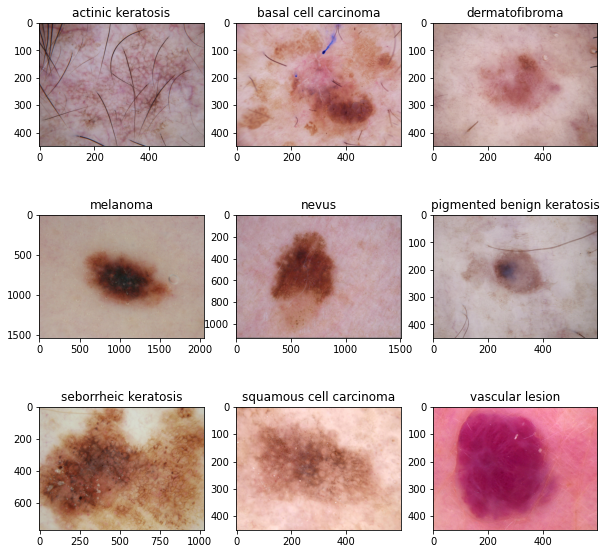

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Model Building & training :**

In [40]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [41]:
### Todo, choose an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 26s 138ms/step - loss: 2.0743 - accuracy: 0.1931 - val_loss: 2.0342 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0350 - accuracy: 0.1881 - val_loss: 2.0301 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0277 - accuracy: 0.1869 - val_loss: 2.0203 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 4s 75ms/step - loss: 1.9897 - accuracy: 0.2115 - val_loss: 2.1960 - val_accuracy: 0.2371
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 1.8851 - accuracy: 0.3002 - val_loss: 1.7176 - val_accuracy: 0.3579
Epoch 6/20
56/56 [==============================] - 4s 76ms/step - loss: 1.7092 - accuracy: 0.3728 - val_loss: 1.7011 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.6341 - accuracy: 0.4029 - val_loss: 1.5993 - val_accuracy: 0.4206
Epoch 8/20
56/56 [====

### Visualizing training results

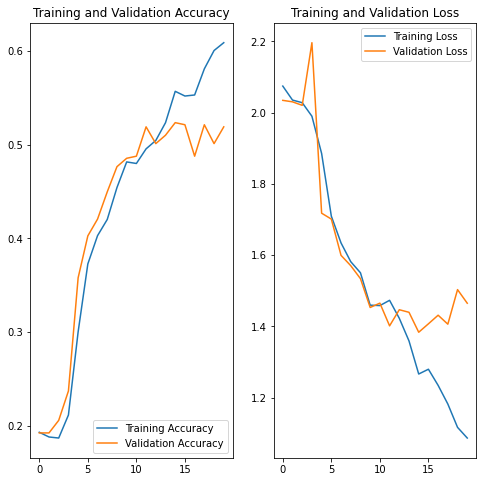

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings on the base model**

- The training accuracy is more as compared to validation accuracy, so we can say that the model is overfitting.

- Also we can see the difference in loss functions in training & validation around the 8-9th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- Lets further train model with increased epochs to check of this issue gets resolved.


Data augumentation strategy

In [45]:
# After we have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

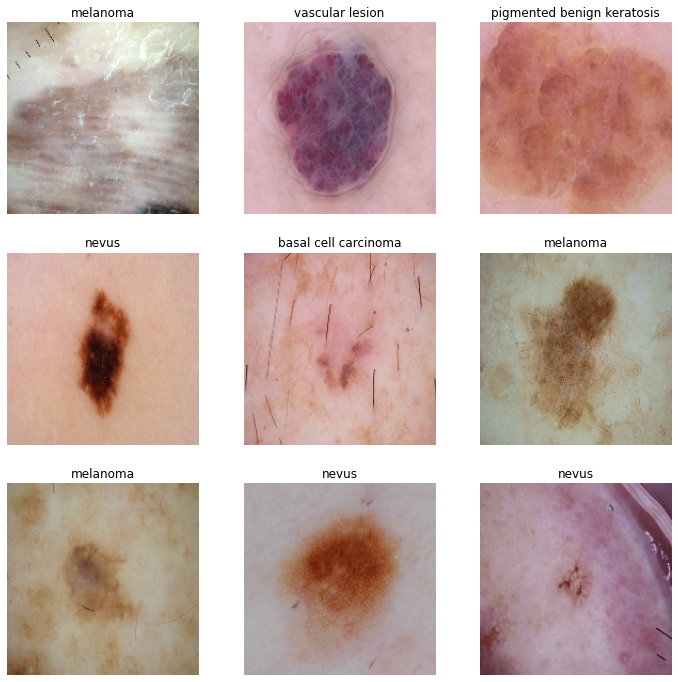

In [46]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [47]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [49]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 7s 91ms/step - loss: 2.0465 - accuracy: 0.2126 - val_loss: 1.9060 - val_accuracy: 0.3110
Epoch 2/30
56/56 [==============================] - 5s 86ms/step - loss: 1.8851 - accuracy: 0.2930 - val_loss: 2.0344 - val_accuracy: 0.2438
Epoch 3/30
56/56 [==============================] - 5s 86ms/step - loss: 1.7999 - accuracy: 0.3387 - val_loss: 1.9402 - val_accuracy: 0.3356
Epoch 4/30
56/56 [==============================] - 5s 86ms/step - loss: 1.7526 - accuracy: 0.3616 - val_loss: 1.6877 - val_accuracy: 0.3781
Epoch 5/30
56/56 [==============================] - 5s 86ms/step - loss: 1.6406 - accuracy: 0.4046 - val_loss: 1.8135 - val_accuracy: 0.3356
Epoch 6/30
56/56 [==============================] - 5s 86ms/step - loss: 1.6032 - accuracy: 0.4196 - val_loss: 1.5251 - val_accuracy: 0.4698
Epoch 7/30
56/56 [==============================] - 5s 86ms/step - loss: 1.5766 - accuracy: 0.4436 - val_loss: 1.6271 - val_accuracy: 0.4161
Epoch 8/30
56

### Visualizing the results

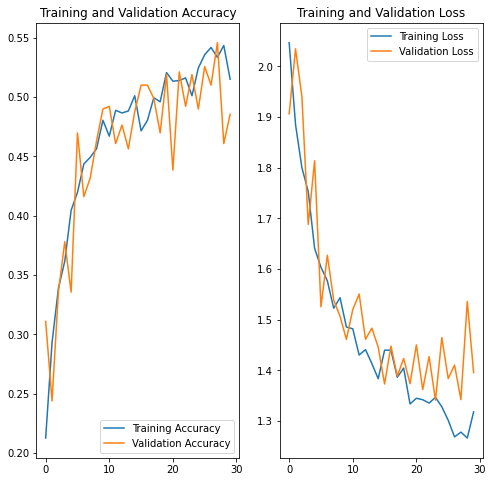

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Finding from Second Model**

- The model is improved as the problem of overfitting is eradicated from it.

- But there is scope of improvement in the accuracy of the model. For this we can try increasing the epochs and retrain the model.

#### **Find the distribution of classes in the training dataset.**
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [51]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### Class imbalance findings: 
#### - **seborrheic keratosis** class has the least number of samples.
#### - **pigmented benign keratosis** & **melanoma** classes dominate the data in terms proportionate number of samples.

#### **Rectify the class imbalance**

In [52]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [54]:
import Augmentor
import os
train_path = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
  p = Augmentor.Pipeline(train_path,save_format='jpg')
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7FBF525B1DD0>: 100%|██████████| 500/500 [00:47<00:00, 10.48 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF531A8650>: 100%|██████████| 500/500 [00:41<00:00, 11.97 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF523477D0>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF5314AF10>: 100%|██████████| 500/500 [00:41<00:00, 11.95 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF5313B0D0>: 100%|██████████| 500/500 [00:51<00:00,  9.70 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF53737C90>: 100%|██████████| 500/500 [00:42<00:00, 11.88 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF5260B850>: 100%|██████████| 500/500 [00:42<00:00, 11.68 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FBF53102850>: 100%|██████████| 500/500 [00:46<00:00, 10.75 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBF53EF5190>: 100%|██████████| 500/500 [00:43<00:00, 11.46 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
data_dir = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/")
image_count_train = len(list(data_dir.glob('*/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.


In [94]:
for i in class_names:
    for j in data_dir.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df


,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6735,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6736,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
6737,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [57]:
new_df['Label'].value_counts()

pigmented benign keratosis    1381
melanoma                      1317
basal cell carcinoma          1140
nevus                         1100
squamous cell carcinoma        555
vascular lesion                434
actinic keratosis              327
dermatofibroma                 268
seborrheic keratosis           217
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [148]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [149]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Todo:** Create a validation dataset

In [150]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [151]:
## We can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [152]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [153]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
113/113 [==============================] - 22s 183ms/step - loss: 1.8997 - accuracy: 0.2853 - val_loss: 1.7459 - val_accuracy: 0.3411
Epoch 2/20
113/113 [==============================] - 21s 180ms/step - loss: 1.6675 - accuracy: 0.3983 - val_loss: 1.6172 - val_accuracy: 0.4433
Epoch 3/20
113/113 [==============================] - 22s 181ms/step - loss: 1.5858 - accuracy: 0.4433 - val_loss: 1.5859 - val_accuracy: 0.4444
Epoch 4/20
113/113 [==============================] - 22s 182ms/step - loss: 1.4866 - accuracy: 0.4753 - val_loss: 1.4262 - val_accuracy: 0.4967
Epoch 5/20
113/113 [==============================] - 22s 184ms/step - loss: 1.3777 - accuracy: 0.5175 - val_loss: 1.5112 - val_accuracy: 0.5289
Epoch 6/20
113/113 [==============================] - 22s 184ms/step - loss: 1.3032 - accuracy: 0.5453 - val_loss: 1.4232 - val_accuracy: 0.5033
Epoch 7/20
113/113 [==============================] - 21s 180ms/step - loss: 1.1931 - accuracy: 0.5747 - val_loss: 1.1726 - val_ac

#### **Todo:**  Visualize the model results

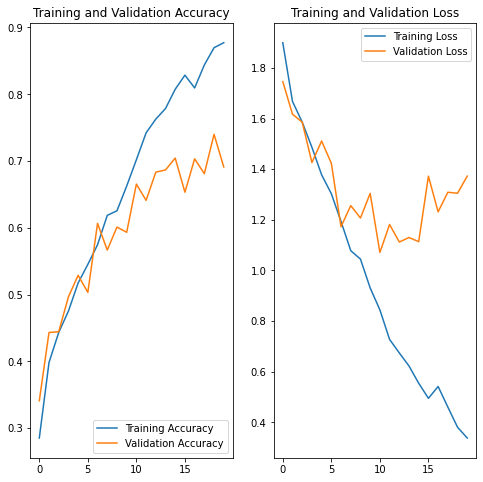

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Conclusions:**
- The model fits well while we increased epochs for training.
- Training accuracy and validation accuracy are forming a increasing pattern. Although we can observe overfitting.
- The results can be further improved by increasing th epochs and fine tuning hyperparameters